In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import combinations
from tqdm import tqdm


In [6]:
path = '/Users/g_private/Library/CloudStorage/OneDrive-Personal/Universität Zürich/FS25/Complex Newtworks Yas/data/co-attention.csv'
df=pd.read_csv(path)
df=df.dropna()
df['countries_mentioned_list']=df['countries_mentioned'].apply(lambda x: x.split(','))
df['affiliations_list']=df['affiliations'].apply(lambda x: x.split(','))
df['Mention_number']=df['countries_mentioned_list'].apply(lambda x: len(x))
df['countries_mentioned_list'] = df['countries_mentioned_list'].apply(
    lambda lst: [c.strip().title()           # remove spaces, standard capitalisation
                 .replace('P.R. China', 'China')
                 .replace('Pr China', 'China')
                 .replace('People’s Republic Of China', 'China')
                 .replace('Cn', 'China')
                 for c in lst]
)
df['affiliations_list'] = df['affiliations_list'].apply(
    lambda lst: [c.strip().title()           # remove spaces, standard capitalisation
                 .replace('P.R. China', 'China')
                 .replace('Pr China', 'China')
                 .replace('People’s Republic Of China', 'China')
                 .replace('Cn', 'China')
                 for c in lst])
# flatten with respect to to the aggregated_value column
df = df.loc[df.index.repeat(df['aggregated_value'])].reset_index(drop= True)

df['affiliations_list'] = df['affiliations_list'] \
    .apply(lambda codes: [c.upper() for c in codes])


# List of columns to remove
cols_to_drop = [
    'countries_mentioned',
    'affiliations',
    'aggregated_value',
    #'affiliations_list',
    'Mention_number'
]

# Option 1: create a new DataFrame without those columns
df= df.drop(columns=cols_to_drop)

df['countries_mentioned_list'] = df['countries_mentioned_list'] \
    .apply(lambda codes: [c.upper() for c in codes])
# remove entries with only 1 country mentioned
df = df[df['countries_mentioned_list'].apply(len) > 1]

df['countries_mentioned_list'] = df['countries_mentioned_list'].apply(lambda lst:[c for c in lst if len(c) < 4]) 

df = df[df['countries_mentioned_list'].apply(len) > 1]


Scale factor applied to gravity weights: 0.0035
Total fractional co-mentions: 348078.00
Total gravity weight: 348078.00


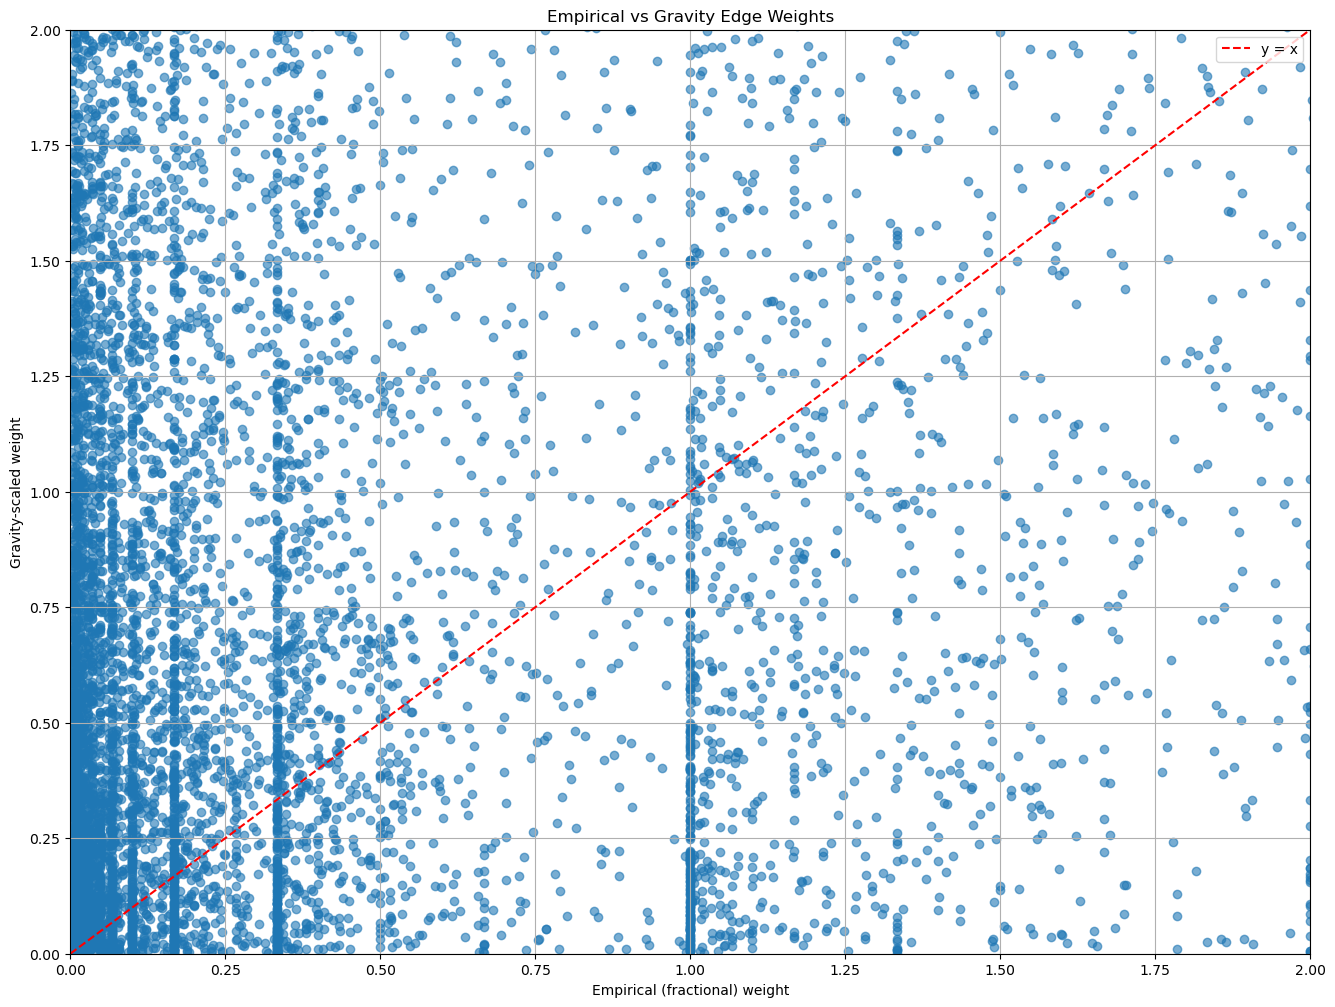

In [7]:
import pandas as pd
import itertools
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
import math

# --- 0. Load ISO3 coordinates and clean them ---
url = "https://gist.githubusercontent.com/tadast/8827699/raw/countries_codes_and_coordinates.csv"
df_coords = pd.read_csv(url)

df_coords["Alpha-3 code"] = (
    df_coords["Alpha-3 code"]
    .astype(str)
    .str.replace('"', '', regex=False)
    .str.strip()
)

df_coords["Longitude (average)"] = (
    df_coords["Longitude (average)"]
    .astype(str)
    .str.replace('"', '', regex=False)
    .astype(float)
)

df_coords["Latitude (average)"] = (
    df_coords["Latitude (average)"]
    .astype(str)
    .str.replace('"', '', regex=False)
    .astype(float)
)

valid_iso3 = set(df_coords["Alpha-3 code"].unique())

# --- 1. Compute geographic distance ---
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) ** 2 +
         math.cos(math.radians(lat1)) *
         math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) ** 2)
    c = 2 * math.asin(math.sqrt(a))
    return R * c

def compute_distance(iso1, iso2):
    iso1, iso2 = iso1.upper(), iso2.upper()
    if iso1 == iso2:
        return 0
    if iso1 not in valid_iso3 or iso2 not in valid_iso3:
        return None
    lat1, lon1 = df_coords.loc[df_coords["Alpha-3 code"] == iso1, ["Latitude (average)", "Longitude (average)"]].values[0]
    lat2, lon2 = df_coords.loc[df_coords["Alpha-3 code"] == iso2, ["Latitude (average)", "Longitude (average)"]].values[0]
    return haversine(lat1, lon1, lat2, lon2)


# --- 3. Build gravity-scaled graph ---
def build_scaled_gravity_graph(df, list_col='countries_mentioned_list', min_weight=0.0):
    country_counts = Counter()
    for countries in df[list_col]:
        valid_countries = set(c for c in countries if c in valid_iso3)
        for c in valid_countries:
            country_counts[c] += 1

    pair_counts = Counter()
    for countries in df[list_col]:
        uniq = sorted(set(c for c in countries if c in valid_iso3))
        n = len(uniq)
        if n < 2:
            continue
        weight = 1 / (n * (n - 1) / 2)
        for u, v in itertools.combinations(uniq, 2):
            pair_counts[(u, v)] += weight

    raw_Fij = {}
    for (u, v), _ in pair_counts.items():
        Mi, Mj = country_counts[u], country_counts[v]
        Dij = compute_distance(u, v)
        if isinstance(Dij, (int, float)) and Dij > 0:
            raw_Fij[(u, v)] = (Mi * Mj) / Dij

    S_raw = sum(raw_Fij.values())
    S_target = sum(pair_counts.values())
    scale_factor = S_target / S_raw if S_raw > 0 else 0

    G_gravity = nx.Graph()
    for (u, v), Fij_raw in raw_Fij.items():
        Fij_scaled = Fij_raw * scale_factor
        if Fij_scaled >= min_weight:
            G_gravity.add_edge(u, v, weight=Fij_scaled)

    return G_gravity, country_counts, pair_counts, scale_factor

# --- 4. Build empirical (fractional) graph ---
def build_fractional_graph(pair_counts, min_weight=0.0):
    G_empirical = nx.Graph()
    for (u, v), weight in pair_counts.items():
        if weight >= min_weight:
            G_empirical.add_edge(u, v, weight=weight)
    return G_empirical

# --- 5. Plot graph ---
def plot_graph(G, title="Co-mention Network"):
    pos = nx.spring_layout(G, seed=42, k=1)
    weights = nx.get_edge_attributes(G, 'weight')
    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue', edgecolors='black')
    nx.draw_networkx_edges(G, pos, width=[w * 2 for w in weights.values()], alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title(title)
    plt.axis('off')
    plt.show()

# --- 6. Run everything ---
G_gravity, Mi_counts, Cij_counts, scale = build_scaled_gravity_graph(df)
G_empirical = build_fractional_graph(Cij_counts)

print(f"Scale factor applied to gravity weights: {scale:.4f}")
print(f"Total fractional co-mentions: {sum(Cij_counts.values()):.2f}")
print(f"Total gravity weight: {sum(nx.get_edge_attributes(G_gravity, 'weight').values()):.2f}")

#plot_graph(G_gravity, title="Gravity-scaled co-mention network")
#plot_graph(G_empirical, title="Empirical fractional co-mention network")

# --- 7. Plot scatter comparison between the two graphs ---
gravity_weights = nx.get_edge_attributes(G_gravity, "weight")
empirical_weights = nx.get_edge_attributes(G_empirical, "weight")

common_edges = set(gravity_weights.keys()) & set(empirical_weights.keys())
x_vals = [empirical_weights[e] for e in common_edges]
y_vals = [gravity_weights[e] for e in common_edges]

def plot_empirical_vs_gravity(G_empirical, G_gravity, xlim_max=None):
    gravity_weights = nx.get_edge_attributes(G_gravity, "weight")
    empirical_weights = nx.get_edge_attributes(G_empirical, "weight")

    common_edges = set(gravity_weights.keys()) & set(empirical_weights.keys())
    x_vals = [empirical_weights[e] for e in common_edges]
    y_vals = [gravity_weights[e] for e in common_edges]

    plt.figure(figsize=(16, 12))
    plt.scatter(x_vals, y_vals, alpha=0.6)
    max_val = max(max(x_vals), max(y_vals))
    plt.plot([0, max_val], [0, max_val], linestyle="--", color="red", label="y = x")
    
    if xlim_max:
        plt.xlim(0, xlim_max)
        plt.ylim(0, xlim_max)
    
    plt.xlabel("Empirical (fractional) weight")
    plt.ylabel("Gravity-scaled weight")
    plt.title("Empirical vs Gravity Edge Weights")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with x-axis limited to 0.1
plot_empirical_vs_gravity(G_empirical, G_gravity, xlim_max=2)

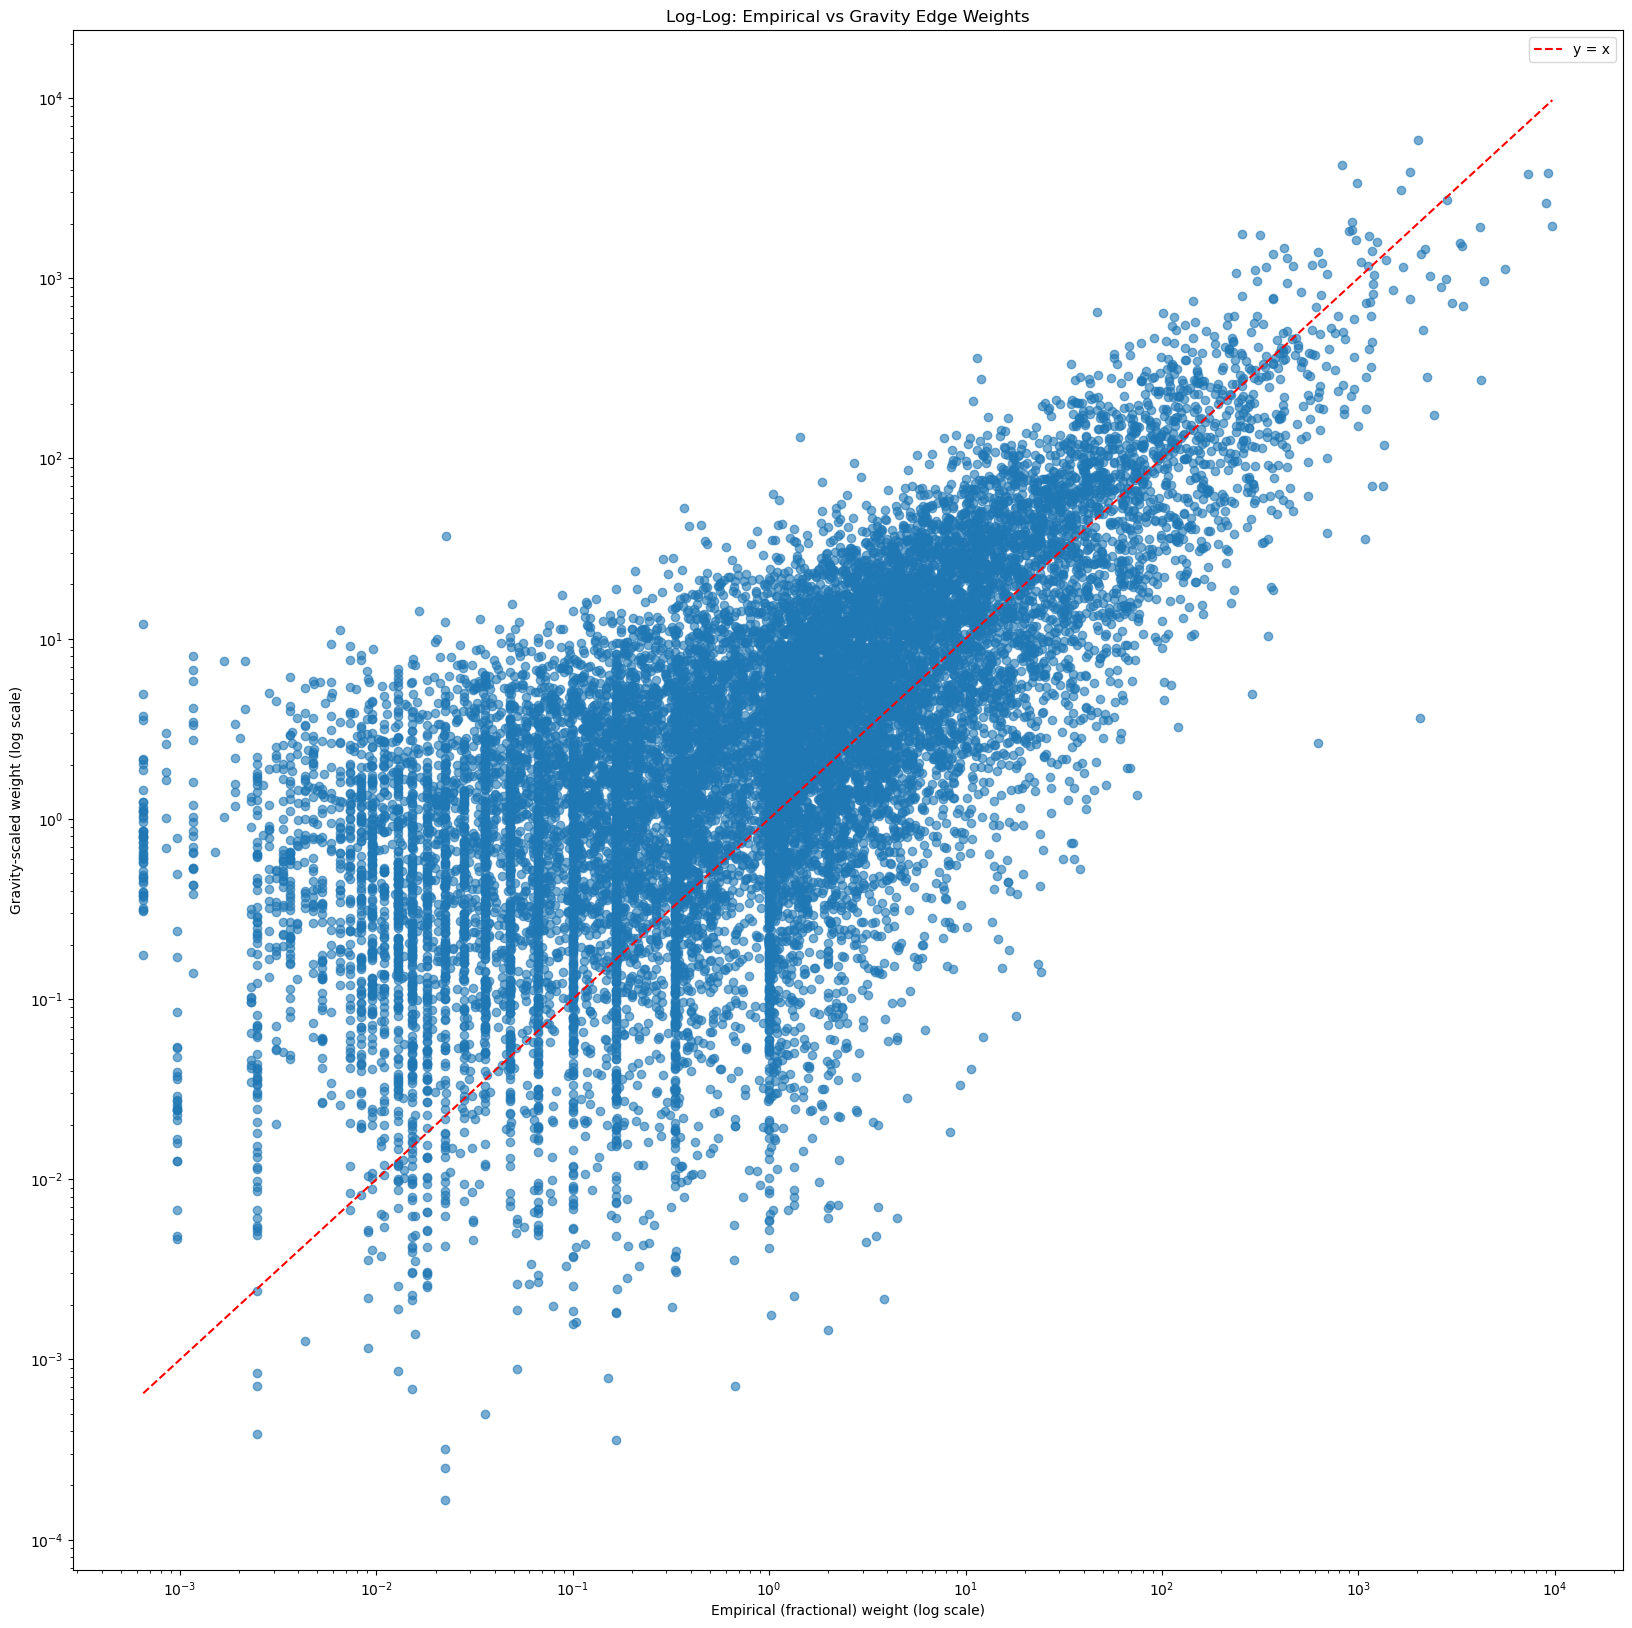

In [8]:
plt.figure(figsize=(20, 20))
plt.scatter(x_vals, y_vals, alpha=0.6)
plt.xscale("log")
plt.yscale("log")
plt.plot([min(x_vals), max(x_vals)], [min(x_vals), max(x_vals)], linestyle="--", color="red", label="y = x")
plt.xlabel("Empirical (fractional) weight (log scale)")
plt.ylabel("Gravity-scaled weight (log scale)")
plt.title("Log-Log: Empirical vs Gravity Edge Weights")
#plt.grid(True, which='both')
plt.legend()
plt.show()


# log values

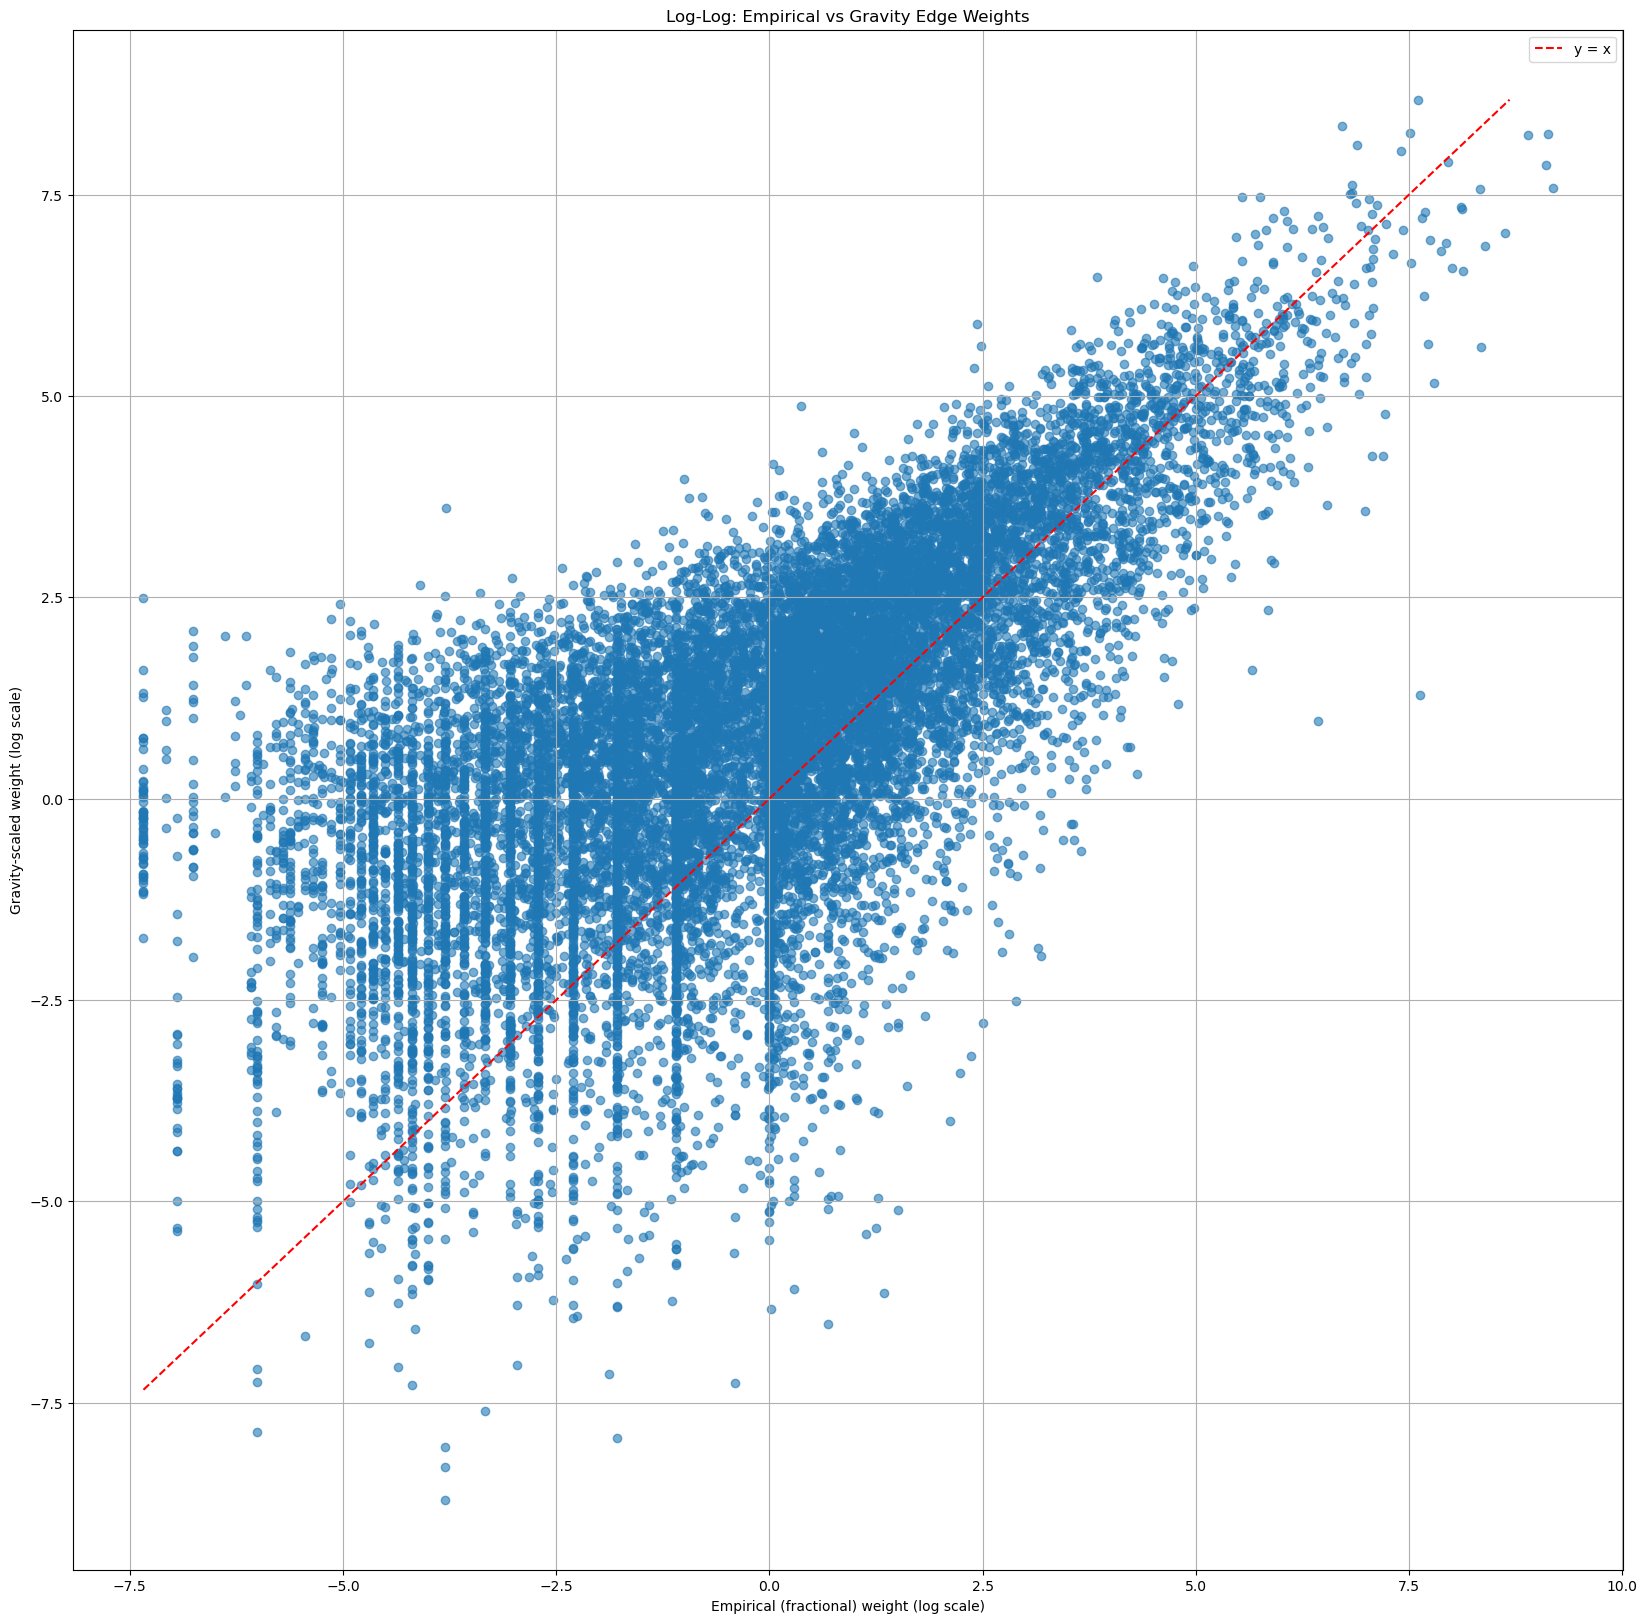

In [16]:
plt.figure(figsize=(20, 20))
plt.scatter(np.log(x_vals), np.log(y_vals), alpha=0.6)
plt.plot([min(np.log(x_vals)), max(np.log(y_vals))], [min(np.log(x_vals)), max(np.log(y_vals))], linestyle="--", color="red", label="y = x")
plt.xlabel("Empirical (fractional) weight (log scale)")
plt.ylabel("Gravity-scaled weight (log scale)")
plt.title("Log-Log: Empirical vs Gravity Edge Weights")
plt.grid(True, which='both')
plt.legend()
plt.show()


Slope: 0.564
Intercept: 0.966 (C ≈ 2.628)


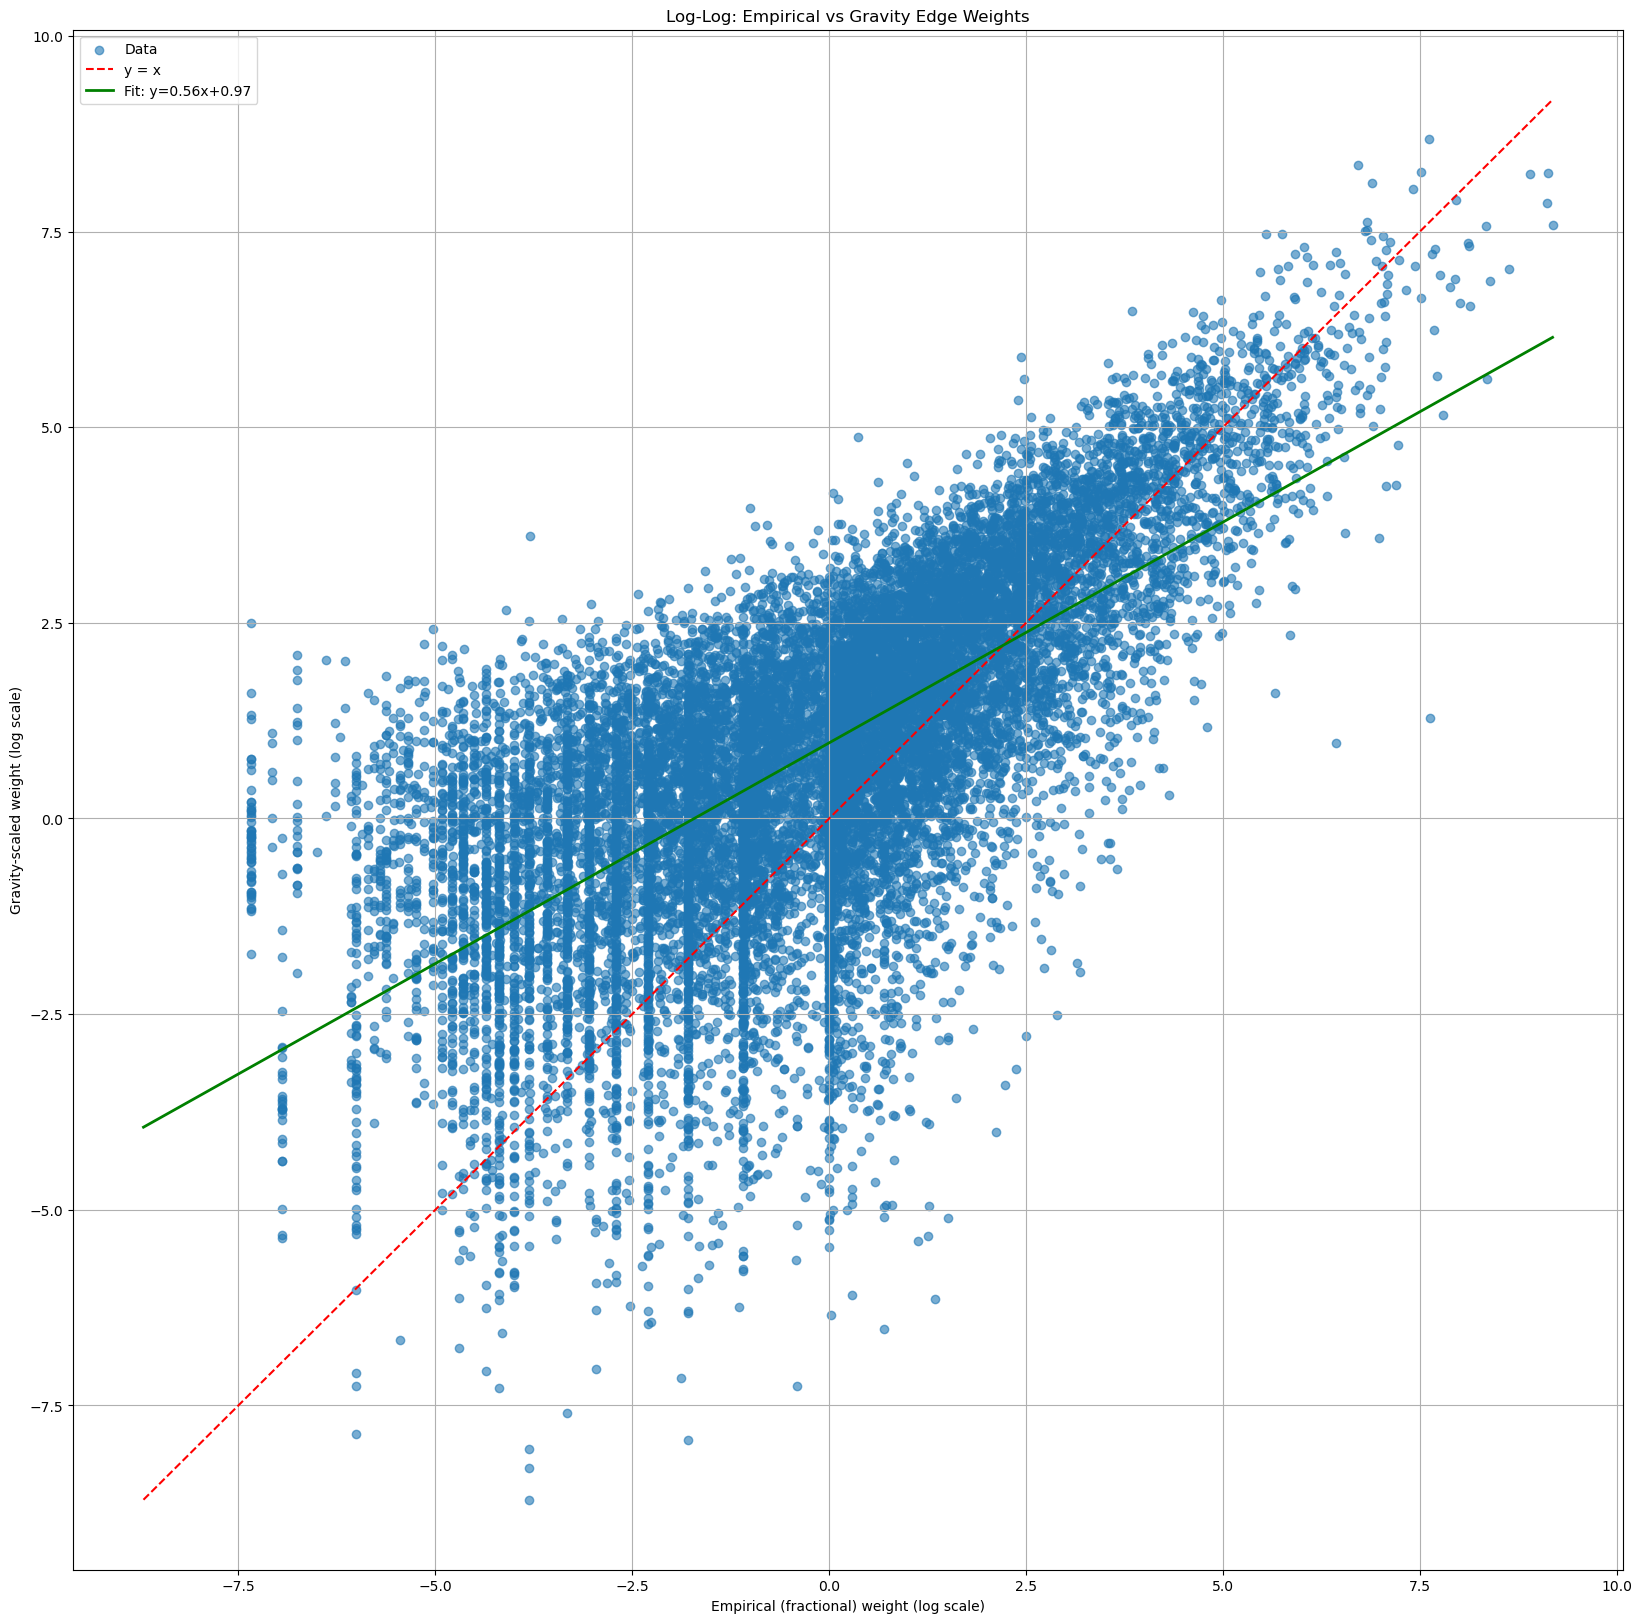

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# log-transform with epsilon
x_log = np.log(x_vals )
y_log = np.log(y_vals)

# linear regression in log space
slope, intercept, r_value, p_value, std_err = linregress(x_log, y_log)

print(f"Slope: {slope:.3f}")
print(f"Intercept: {intercept:.3f} (C ≈ {np.exp(intercept):.3f})")

# scatter
plt.figure(figsize=(20, 20))
plt.scatter(x_log, y_log, alpha=0.6, label="Data")

# y=x reference line
low = min(x_log.min(), y_log.min())
high = max(x_log.max(), y_log.max())
plt.plot([low, high], [low, high], linestyle="--", color="red", label="y = x")

# regression line (in log-log space)
x_fit = np.linspace(low, high, 200)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, color="green", linewidth=2, label=f"Fit: y={slope:.2f}x+{intercept:.2f}")

# labels
plt.xlabel("Empirical (fractional) weight (log scale)")
plt.ylabel("Gravity-scaled weight (log scale)")
plt.title("Log-Log: Empirical vs Gravity Edge Weights")
plt.grid(True, which="both")
plt.legend()
plt.show()


### Log–Log Regression Interpretation

From the regression in log-space:

$$
\log(y) = 0.564 \cdot \log(x) + 0.966
$$

Transforming back to the original scale gives:

$$
y \approx 2.63 \cdot x^{0.564}
$$

**Interpretation:**
- The gravity weights scale with empirical weights in a **sublinear power-law**.
- Since the exponent \(0.564 < 1\), gravity **overpredicts weak ties** and **underpredicts strong ties**.
- The constant \(2.63\) means that when \(x = 1\), gravity predicts a weight about 2.6 times larger.
